# SAT-based minimization of deterministic ω-automata

The `spot.sat_minimize()` Python function is the main entry point for minimizing any **deterministic** ω-automaton.  This notebook demonstrates how to use that function.

**Warning:** while the automata used in this notebook are quite small, working with large automata can require a lot of RAM and take huge amount of time.  In its most straightforward variant, `sat_minimize()` takes a input automaton (called *reference*) and then makes a loop to ask a SAT-solver for an equivalent automaton (called *candidate*) with 1 fewer state at each iteration.   If the reference has size ($n_i$, $s_i$), i.e. $n_i$ states, $s_i$ acceptance sets, and the candidate has size $(n_o, s_o)$, the SAT encoding uses $\mathrm{O}(n_i^2\times n_o^2\times 2^{s_i+s_o})$ variables and $\mathrm{O}(n_i^2 \times n_o^3\times 2^{s_i+2s_o}\times |\Sigma|)$ clauses.  Reducing the number of acceptance set the therefore the most important way to simplify a problem.

In [1]:
import spot
spot.setup(show_default='.b')
from IPython.display import display

## Minimizing DBA

Let's take a simple formula and translate it into a DBA:

In [2]:
f = spot.formula('GF(a <-> XXb)'); f

GF(a <-> XXb)

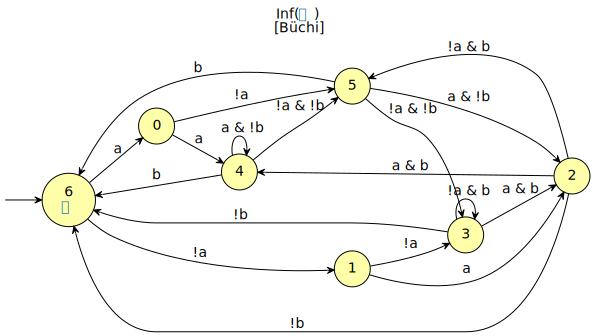

In [3]:
aut = f.translate('det', 'BA'); aut

The above automaton is not minimal and is easily reduced by `sat_minimize()`:

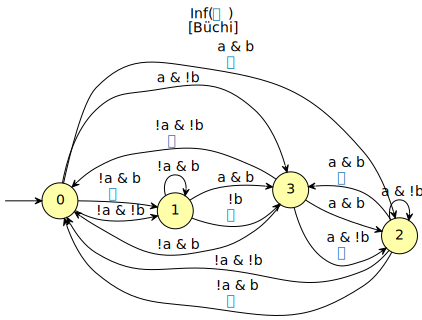

In [4]:
spot.sat_minimize(aut)

Note that by default SAT-minimize produces a transition-based automaton with the same acceptance condition.  State-based acceptance can be requested with the `state_based` option:

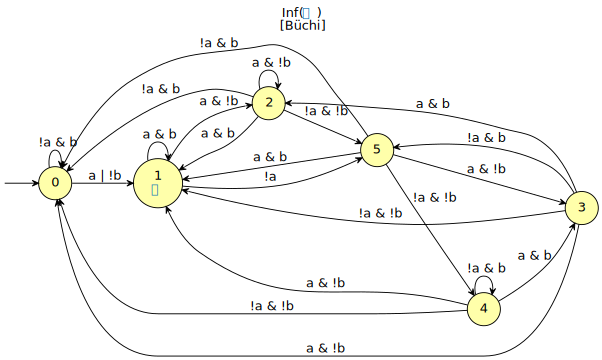

In [5]:
spot.sat_minimize(aut, state_based=True)

## Minimizing deterministic ω-automata with arbitrary acceptance condition

Now let's look at examples with more complicated acceptance conditions.  
The following Rabin automaton was produced using ltl2dstar 0.5.4 and spot 2.5.2 with
```
ltlfilt --lbt -f '(FGa | Fb) & FGc'  | ltl2dstar -H --ltl2nba=spin:ltl2tgba@-Ds - -
```
however we hardcode it so that the notebook can be used even with `ltl2dstar` installed.

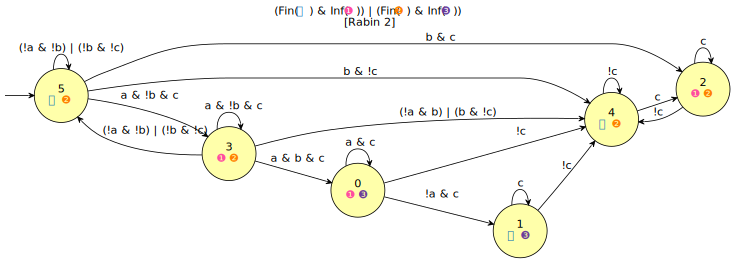

In [6]:
large = spot.automaton('''
HOA: v1 States: 6 properties: implicit-labels trans-labels no-univ-branch
deterministic complete stutter-invariant tool: "ltl2dstar" "0.5.4"
name: "& | F G a F b F G c" comment: "Safra[NBA=4]" acc-name: Rabin 2
Acceptance: 4 (Fin(0)&Inf(1))|(Fin(2)&Inf(3)) Start: 5 AP: 3 "a" "b"
"c" --BODY-- State: 0 {1 3} 4 4 4 4 1 0 1 0 State: 1 {0 3} 4 4 4 4 1 1
1 1 State: 2 {1 2} 4 4 4 4 2 2 2 2 State: 3 {1 2} 5 5 4 4 5 3 4 0 State:
4 {0 2} 4 4 4 4 2 2 2 2 State: 5 {0 2} 5 5 4 4 5 3 2 2 --END--''')
large.merge_edges()
large

In [7]:
print(large.to_str())

HOA: v1
name: "& | F G a F b F G c"
States: 6
Start: 5
AP: 3 "a" "c" "b"
acc-name: Rabin 2
Acceptance: 4 (Fin(0) & Inf(1)) | (Fin(2) & Inf(3))
properties: trans-labels explicit-labels state-acc complete
properties: deterministic stutter-invariant
--BODY--
State: 0 {1 3}
[0&1] 0
[!0&1] 1
[!1] 4
State: 1 {0 3}
[1] 1
[!1] 4
State: 2 {1 2}
[1] 2
[!1] 4
State: 3 {1 2}
[0&1&2] 0
[0&1&!2] 3
[!0&2 | !1&2] 4
[!0&!2 | !1&!2] 5
State: 4 {0 2}
[1] 2
[!1] 4
State: 5 {0 2}
[1&2] 2
[0&1&!2] 3
[!1&2] 4
[!0&!2 | !1&!2] 5
--END--


It can be minimized as a 2-state transition-based Rabin:

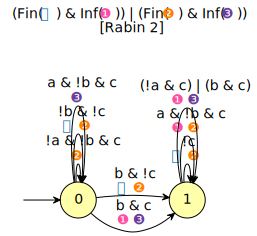

In [8]:
small = spot.sat_minimize(large); small

Or as a 4-state state-based Rabin:

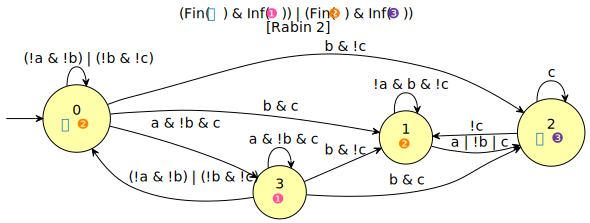

In [9]:
spot.sat_minimize(large, state_based=True)

But do we really need 2 rabin pairs?  Let's ask if we can get an equivalent with only one pair.  (Note that reducing the number of pairs might require more state, but the `sat_minimize()` function will never attempt to add state unless explicitely instructed to do so.  In this case we are therefore looking for a state-based Rabin-1 automaton with at most 4 states.)

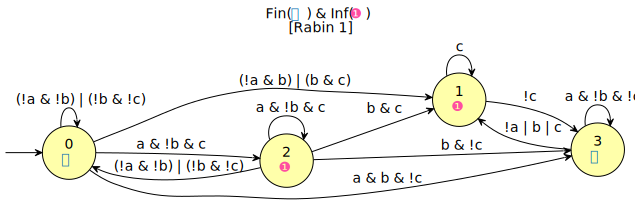

In [10]:
spot.sat_minimize(large, state_based=True, acc='Rabin 1')

Using the `display_log` option, we can have a hint of what is going on under the hood.  Each line in the table shows one call to the SAT solver.  The column labeled `target.states` gives the size of the equivalent automaton we ask the SAT-solver to produce, but some of these states may actually be unreachable in the result.  The `variables` and `clauses` columns give an indication of the size of the SAT problem.  The `enc.*` and `sat.*` columns give the user and system time taken to encode and solve the SAT problem (the unit is "ticks", which usually is 1/100 of seconds).

Below we see that the minimization procedure first tried to squeeze the 6-state input into a 3-state automaton, which failed, and then into a 5-state automaton, which was successful.  This 5-state automaton was used as input to produce a smaller 4-state automaton..  Essentially this procedure is doing a binary search towards the minimal size.  

(In this case it does not matter, but be aware that the number of states displayed in the log table are those of complete automata, while the output of `sat_minimize()` is trimmed by default.)

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,6,3,NaN,NaN,NaN,1428,73430,58,0,1,0
1,6,5,5,16,40,3960,336307,268,1,18,0
2,5,4,4,12,32,2008,116372,92,0,4,0


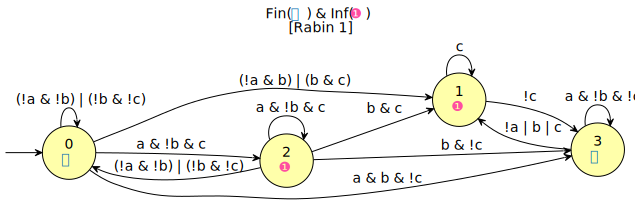

In [11]:
spot.sat_minimize(large, state_based=True, acc='Rabin 1', display_log=True)

Note that we already had a smaller transition-based automaton for this language (in the `small` variable), and that it actually is more efficient to work from that, as seen in problem sizes displayed in the following log.

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,2,3,NaN,NaN,NaN,483,24470,20,0,0,0
1,2,5,5,16,40,1335,111187,88,0,3,0
2,2,4,4,12,32,856,57332,46,0,1,0


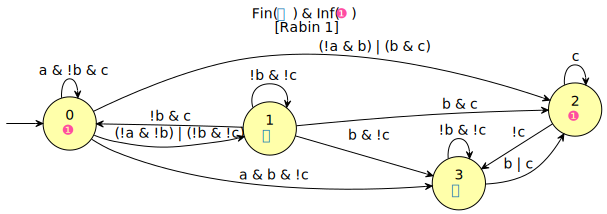

In [12]:
spot.sat_minimize(small, state_based=True, acc='Rabin 1', display_log=True)

How did the procedure look for a complete automaton of size 5 when the input had only 2 states?  It's because the input uses transition-based acceptance: to estimate an upper bound of the size of the state-based output, the `sat_minimize()` procedure converted its transition-based input to state-based acceptance (using the `spot.sbacc()` function) and counted the number of states in the result.

Such an estimate is not necessarily correct of we request a different acceptance condition.  In that case We can actually change the upper-bound using `max_states`.  Below we additionally demonstrate the use of the `colored` option, to request all transition to belong to exactly one set, as customary in parity automata.

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,2,5,5,18,40,3050,437037,441,1,16,1
1,2,2,2,6,16,488,28449,29,0,0,0
2,2,1,NaN,NaN,NaN,68,1285,1,0,0,0


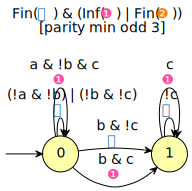

In [13]:
spot.sat_minimize(small, max_states=9, acc='parity min odd 3', colored=True, display_log=True)

There are a couple of ways in which we can influence the search for the minimum automaton.  We can disable the binary search with `sat_naive`.  In this case, the procedure will try to remove one state at a time.  This is not necessary slower than the default binary search, because satisfiable problems are often solved more quickly than unsatisfiable ones.

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,6,6,6,19,48,3894,258719,148,1,5,0
1,6,5,5,15,40,2005,106302,62,0,1,0
2,5,4,4,11,32,676,24632,14,0,0,0
3,4,3,NaN,NaN,NaN,363,10553,7,0,0,0


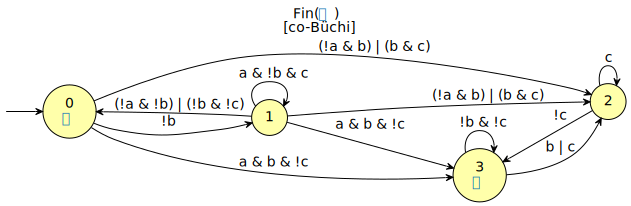

In [14]:
spot.sat_minimize(large, acc='co-Buchi', sat_naive=True, state_based=True, display_log=True)

## Variant for incremental SAT solving

Using `sat_incr=1`, we encode the problem of finding an equivalent automaton with $n$ states, and add 6 additional variables and some additional constraints to the problem:

| variable | implied constraints |
| :--- | ---: |
| $v_1$ | transitions to state $(n-1)$ must not be used | 
| $v_2$ | $v_1\land{}$ transitions to state $(n-2)$ must not be used |
| ... | |
| $v_6$ | $v_5\land{}$ transitions to state $(n-5)$ must not be used |

Now using `assume` directives on variable $v_i$ amounts to testing whether the problem is solved with $n-i$ states, but we do not have to reencode the problem for each test, and the solver can (probably) reuse some of the knowledge it gathered during a previous attempt.   We do a binary search on these 6 assumptions, to find some $i$ such that the problem is satisfiable with assumption $v_i$ but not with $v_{i+1}$. If such cast exists, we have found the minimal automaton.  If assumption $v_6$ is satisfiable, we re-encode the problem with $n-7$ states and start over.   Watch how the number of variables and clauses do not change in the following log.

The number of assumption variables to use in a one encoding can be set with the `sat_incr_steps` argument.  Its default value of 6 was chosen empirically by benchmarking different values.

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,6,1,NaN,NaN,NaN,3899,258963,151,1,3,0
1,6,3,NaN,NaN,NaN,3899,258963,0,0,0,0
2,6,4,4,11,32,3899,258963,0,0,1,0


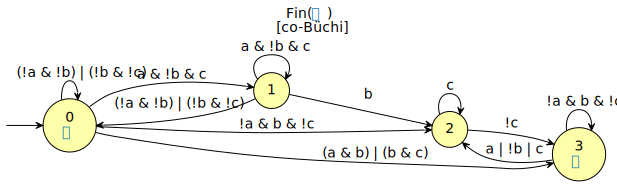

In [15]:
spot.sat_minimize(large, acc='co-Buchi', sat_incr=1, state_based=True, display_log=True)

Another incremental variant consists is the equivalent of forcing $v_1$, $v_2$, ... in order.  But to do that we do not need to use any assumption.  We just add the constraints that transitions going to state $n-i$ are forbidden.  This variant is enabled by option `sat_incr=2`.  As in the previous case, we do a few of those incremental steps (2 by default, but that can be changed with the `sat_incr_steps` parameter) and then we reencode the problem to reduce its size.

In the log below, line 0 corresponds to the search of an equivalent automaton with the same size, but the simpler co-Büchi acceptance.  It works, and most of the time was spent encoding the problem.  Then for the next two lines, the minimization function looks for automata of size 5 and 4 without reencoding the problem but simply adding a few constraints to disable the relevant transitions.

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,6,6,6,19,48,3894,258719,150,0,5,0
1,6,5,5,14,40,3894,258767,0,0,0,0
2,5,4,4,10,32,3894,258815,0,0,0,0
3,4,3,NaN,NaN,NaN,363,10325,6,0,1,0


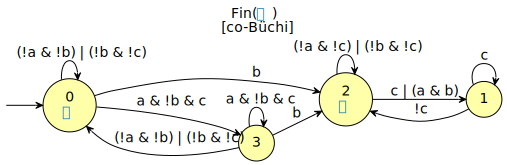

In [16]:
spot.sat_minimize(large, acc='co-Buchi', sat_incr=2, state_based=True, display_log=True)

## Miscellaneous options

### `return_log`

The `return_log` can be used to obtain the log table as an object.  In that case, `sat_minimize()` returns a pair, `(aut,log)` where `aut` can be `None` if the minimization failed.  Also, the `log` table contains an extra column that is hidden by `display_log`: it contains the corresponding automaton in HOA format.

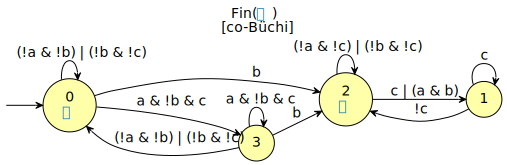

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys,automaton
0,6,6,6,19,48,3894,258719,150,2,5,0,"HOA: v1 States: 6 Start: 0 AP: 3 ""a"" ""c"" ""b"" a..."
1,6,5,5,14,40,3894,258767,0,0,1,0,"HOA: v1 States: 5 Start: 0 AP: 3 ""a"" ""c"" ""b"" a..."
2,5,4,4,10,32,3894,258815,0,0,0,0,"HOA: v1 States: 4 Start: 0 AP: 3 ""a"" ""c"" ""b"" a..."
3,4,3,NaN,NaN,NaN,363,10325,7,0,0,0,NaN


In [17]:
aut, log = spot.sat_minimize(large, acc='co-Buchi', sat_incr=2, state_based=True, return_log=True)
display(aut)
display(log)

Here is how we can extract the automata from that log:

automaton from line 0:


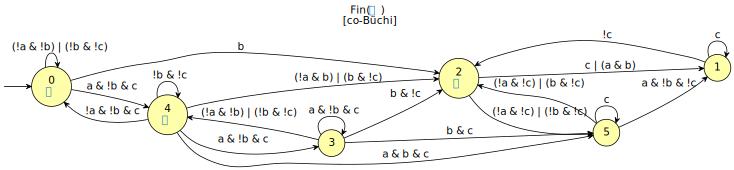

automaton from line 1:


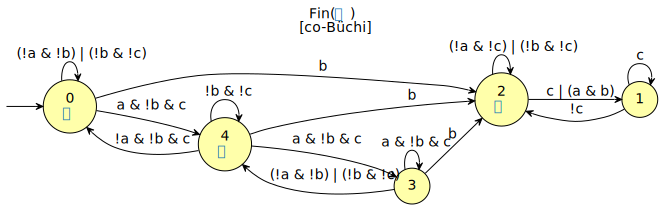

automaton from line 2:


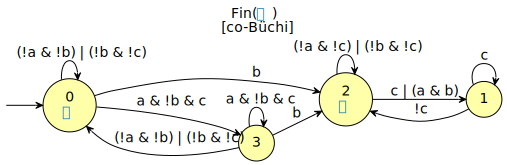

In [18]:
for line, data in log.iterrows():
    if type(data.automaton) is str:
        print("automaton from line {}:".format(line))
        display(spot.automaton(data.automaton + "\n"))

## `sat_langmap`

When using the default binary search approach, the `sat_langmap=True` can help refine the lower bound by first testing the language-equivalence of all states in the automaton.  This allows to form equivalence classes of states, and clearly the minimal automaton needs at least as many states as the number of equivalence states.

For instance in the `large` automaton we use as example, the 6 states correspond to only two different languages.  This can be seen with the `highlight_language()` function, which colors states with identical languages.  This information can be used by the minimization function to search a minimal automaton between 2 and 6 states.

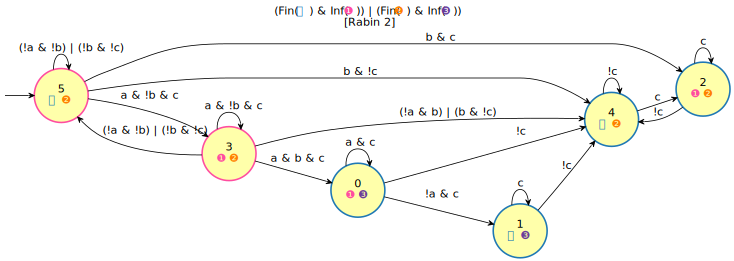

In [19]:
spot.highlight_languages(large); large

Compare the next two logs, with and without `sat_langmap`.

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,6,3,NaN,NaN,NaN,975,32912,20,1,0,0
1,6,5,4,10,32,2705,150257,87,0,2,0


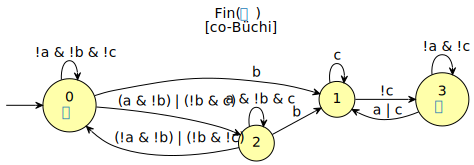

In [20]:
# Binary search between 1 and 6
spot.sat_minimize(large, acc='co-Buchi', state_based=True, display_log=True)

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,6,4,4,12,32,1732,77340,45,0,1,0
1,4,2,NaN,NaN,NaN,162,3129,2,0,0,0
2,4,3,NaN,NaN,NaN,363,10496,6,0,0,0


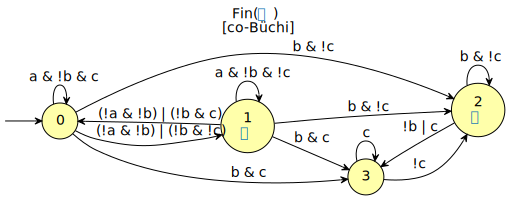

In [21]:
# Binary search between 2 and 6 thanks to sat_langmap
spot.sat_minimize(large, acc='co-Buchi', sat_langmap=True, state_based=True, display_log=True)

### `states`

Sometimes we do not want a minimization loop, we just want to generate an equivalent automaton with a given number of states.  In that case, we use the `states` option.  However there is no constraint that all state should be reachable, so in the end, you could end with an automaton with fewer states than requested.

,input.states,target.states,reachable.states,edges,transitions,variables,clauses,enc.user,enc.sys,sat.user,sat.sys
0,2,7,5,14,40,1869,135032,80,1,2,0


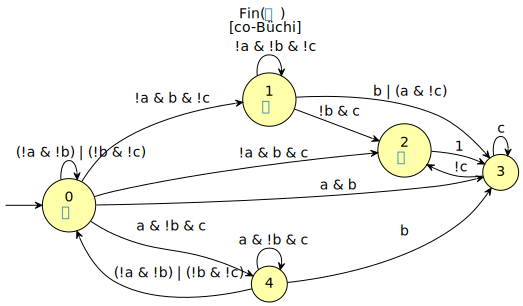

In [22]:
spot.sat_minimize(small, acc="co-Buchi", states=7, state_based=True, display_log=True)